In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset, test_dataset_visob, TestSampler2, test_dataset_2, test_dataset
from twrap.transform import ToZNorm

from twrap.utils import genROC

from torch.utils.data import Dataset

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob

from skimage import transform as T

from sklearn.metrics import roc_curve

import bcolz

from time import time

In [2]:
class dataset_bcolz(Dataset):
    def __init__(self, feat_1, locs_1, labels_1, feat_2, locs_2, labels_2):

        self.feat_1   = feat_1
        self.locs_1   = locs_1
        self.labels_1 = labels_1
        self.feat_2   = feat_2
        self.locs_2   = locs_2
        self.labels_2 = labels_2

    def __getitem__(self, ij):
        f1 = self.feat_1[ij[0],...]
        l1 = self.locs_1[ij[0],...]
        t1 = self.labels_1[ij[0]]
        
        f2 = self.feat_2[ij[1],...]
        l2 = self.locs_2[ij[1],...]
        t2 = self.labels_2[ij[1]]
        id2= ij[1]
        
        return f1, l1, t1, f2, l2, t2, str(id2)
    def __len__(self):
        return len(self.labels_1) * len(self.labels_2)

class bcolzsampler(object):
    def __init__(self, nb1, nb2, batch_size):

        self.nb1 = nb1
        self.nb2 = nb2
        self.batch_size = batch_size

    def __iter__(self):
        batch = []
        for i in range(self.nb1):
            for j in range(self.nb2):
                batch.append([i, j])
                if len(batch) == self.batch_size:
                    yield batch
                    batch = []
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return (self.nb1 * self.nb2 + self.batch_size - 1) // self.batch_size


In [5]:
transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(144),
    transforms.CenterCrop(128),
    ToZNorm()
    ])
dst_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER'

In [6]:
weights_dir = '/media/narsi/LargeData/SP2019/ocularnetv2.1/SPHERE/MODEL1/weights'

model_instance_name = 'MODEL2_ATTEN1_SPH_COMB_C128_SALL_ROT20_SCALE80-100_BLUR0-1.5_COLORJIT'#

model = MODEL2(400, classify = False, attention = True)
check_point_file = weights_dir+ os.sep +model_instance_name + '/model_best.pth.tar'
checkpoint = torch.load(check_point_file, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()
print('.')

.


In [7]:
class extract_features(object):
    def __init__(self, topk = 256, feat_size = (32, 32)):
        self.topk = topk
        
        self.locs = torch.from_numpy(np.zeros((2, feat_size[0]* feat_size[1]), dtype = np.int64))
            
        c = 0
        for i in range(feat_size[0]):
            for j in range(feat_size[1]):
                self.locs[0, c] = i
                self.locs[1, c] = j
                c += 1
        
    def __call__(self, feat, atten):
        
        b, f, h, w = feat.size()
        
        atten = atten.view(b, 1, -1)
        _, atten_idx = atten.sort(dim = -1, descending = True)
        
        feat = feat.view(b, f, -1)
        
        feat_loc = torch.zeros(b, 2, self.topk).long()
        
        for i in range(b):
            feat[i, :, :] = feat[i, :, atten_idx[i, 0, :]]
            feat_loc[i, :, :] = self.locs[:, atten_idx[i, 0, :self.topk]]
        
        return feat[..., :self.topk].data.cpu().numpy(), feat_loc[..., :self.topk].data.cpu().numpy()

In [48]:
def generate_match_scores(f1, l1, f2, l2, cuda = True, d = 1):
    b, f, p = f1.size()
    
    x1_1 = l1 * 0 + 1
    x1_1[:, 0, :] = l1[:, 0, :]
    x1_1 = x1_1.transpose(1, 2).contiguous()
    x1_2 = l1 * 0 + 1
    x1_2[:, 1, :] = l1[:, 1, :]
    x1_2 = x1_2.transpose(1, 2).contiguous()
    
    y2_1 = l2 * 0 + 1
    y2_1[:, 1, :] = -1 * l2[:, 0, :]
    y2_2 = l2 * 0 + 1
    y2_2[:, 0, :] = -1 * l2[:, 1, :]
    
    x1_1 = x1_1.float()
    x1_2 = x1_2.float()

    y2_1 = y2_1.float()
    y2_2 = y2_2.float()
    
    if cuda:
        x1_1 = x1_1.cuda()
        x1_2 = x1_2.cuda()
        
        y2_1 = y2_1.cuda()
        y2_2 = y2_2.cuda()
        
        f1 = f1.cuda()
        f2 = f2.cuda()
        
    z = torch.max(torch.abs(torch.bmm(x1_1, y2_1)), torch.abs(torch.bmm(x1_2, y2_2)))[0]
    z = torch.where(z <= d, torch.ones_like(z), torch.zeros_like(z))
    z_sum = torch.sum((torch.sum(z, dim = -1)>0).float(), dim = -1)
    
    
    f1 = f1.transpose(1, 2).contiguous()
    
    score_matrix = torch.bmm(f1, f2)
    
#     score_matrix = (((score_matrix * z).max(-1)[0]).sum(-1)/z_sum)
    
    return score_matrix.data.cpu().numpy(), z.data.cpu().numpy()

In [40]:
img1 = transform(Image.open('/media/narsi/fast_drive/CCRops/visob/imgs/EC_VISIT_1/IPHONE/office/S1/1151_l_2.png'))
img2 = transform(Image.open('/media/narsi/fast_drive/CCRops/visob/imgs/EC_VISIT_1/IPHONE/office/S2/1151_l_1.png'))

input_var = tensor_to_torch_var(img1.unsqueeze(0), True)
f1_32, f1_16, a1_32, a1_16 = model.getLocalFeat(input_var)

input_var = tensor_to_torch_var(img2.unsqueeze(0), True)
f2_32, f2_16, a2_32, a2_16 = model.getLocalFeat(input_var)

In [41]:
EF_16x16 = extract_features(topk = 128, feat_size = (16, 16))
EF_32x32 = extract_features(topk = 512, feat_size = (32, 32))

In [42]:
f1_32, a1_32 = EF_32x32(f1_32, a1_32)
f2_32, a2_32 = EF_32x32(f2_32, a2_32)

f1_32 = torch.from_numpy(f1_32)
a1_32 = torch.from_numpy(a1_32)
f2_32 = torch.from_numpy(f2_32)
a2_32 = torch.from_numpy(a2_32)

In [49]:
s, z = generate_match_scores(f1_32, a1_32, f2_32, a2_32, cuda = False, d = 3)

In [57]:
s1 = s[0, ...]

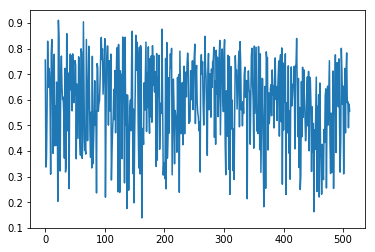

In [62]:
plt.plot(np.max(s1 * s, axis = -1)[0, ...])

In [4]:
def gen_and_save_features(visit, device, light, eye, sess, dst_fldr):
    src_fldr = '/media/narsi/fast_drive/CCRops/visob/imgs/'+visit+'/'+device+'/'+light
    imgs = glob(src_fldr + os.sep + sess + os.sep + '*_'+eye+'_*.png')
    
    dataset = test_dataset(imgs, transform)
    dataset_loader = DataLoader(dataset, num_workers=8, pin_memory=True, batch_size = 64, shuffle=False)
    dataset_loader.batch_sampler.drop_last = False
    
    feat_dst_fldr = dst_fldr + os.sep + visit + os.sep + device + os.sep + light + os.sep + sess + '_' +  eye
    
    if not os.path.exists(feat_dst_fldr):
        os.makedirs(feat_dst_fldr)
    
    bc_init = True
    
    image_names = []
    
    for (img, sub_id) in tqdm(dataset_loader):
        image_names += sub_id
        input_var = tensor_to_torch_var(img, True)
        f32, f16, a32, a16 = model.getLocalFeat(input_var)
        del input_var
        
        f32, a32 = EF_32x32(f32, a32)
        f16, a16 = EF_16x16(f16, a16)
        
        if bc_init:
            store_32_feat = bcolz.carray(f32, rootdir=feat_dst_fldr+os.sep+'feat32', cparams = bcolz.cparams(clevel=0))
            store_32_locs = bcolz.carray(a32, rootdir=feat_dst_fldr+os.sep+'locs32', cparams = bcolz.cparams(clevel=0))
            
            store_16_feat = bcolz.carray(f16, rootdir=feat_dst_fldr+os.sep+'feat16', cparams = bcolz.cparams(clevel=0))
            store_16_locs = bcolz.carray(a16, rootdir=feat_dst_fldr+os.sep+'locs16', cparams = bcolz.cparams(clevel=0))
            
            bc_init = False
        else:
            store_32_feat.append(f32)
            store_32_locs.append(a32)
            
            store_16_feat.append(f16)
            store_16_locs.append(a16)
            
        store_32_feat.flush()
        store_32_locs.flush()
        store_16_feat.flush()
        store_16_locs.flush()
    image_names = np.asarray(image_names, dtype = np.object)
    np.save(feat_dst_fldr+os.sep+'labels.npy', image_names)

In [ ]:
data_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER'
dst_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER/SCORES_W16_P64'

visit = 'EC_VISIT_1'
device = 'IPHONE'
light = 'office'
eye = 'l'
sess = 'S1'
gen_and_save_features(visit, device, light, eye, sess, data_fldr)
sess = 'S2'
gen_and_save_features(visit, device, light, eye, sess, data_fldr)

In [5]:
data_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER'
dst_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER/SCORES_W16_P64'

visit1 = 'EC_VISIT_1'
visit2 = 'EC_VISIT_1'
device = 'IPHONE'
light_enroll = 'office'
light_verify = 'office'
eye = 'l'
feat_1 = bcolz.open(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'feat16', mode = 'r')
locs_1 = bcolz.open(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'locs16', mode = 'r')

feat_2 = bcolz.open(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'feat16', mode = 'r')
locs_2 = bcolz.open(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'locs16', mode = 'r')

labels_1 = np.load(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'labels.npy')
labels_2 = np.load(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'labels.npy')


dsbz = dataset_bcolz(feat_1, locs_1, labels_1, feat_2, locs_2, labels_2)
DB = bcolzsampler(len(dsbz.labels_1), len(dsbz.labels_2), 256)
DL = DataLoader(dsbz, num_workers=8, pin_memory=True, shuffle = False, batch_sampler=DB)

scores = []
enroll = []
verify = []
vid = []
for (f1, l1, t1, f2, l2, t2, id2) in tqdm(DL):
    scores.append(generate_match_scores(f1, l1, f2, l2, cuda = True, d = 1))
    enroll += t1
    verify += t2
    vid += id2

scores = np.concatenate(scores)
enroll = np.asarray(enroll, dtype = str)
verify = np.asarray(verify, dtype = str)
vid = np.asarray(vid, dtype = str)

100%|██████████| 48007/48007 [14:36<00:00, 54.76it/s]


In [12]:
scores[1]

0.19992565

In [10]:
enroll[0]

'1151l'

In [1]:
np.where(targets == 1)[0][0]

NameError: name 'np' is not defined

In [6]:
targets = 1 * (enroll == verify)

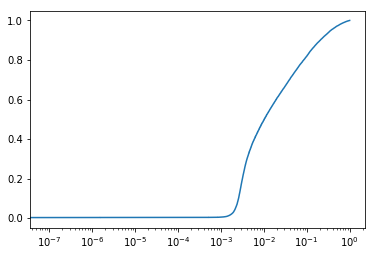

In [7]:
far, tar, _ = roc_curve(1 * (enroll == verify), scores)
plt.semilogx(far, tar)

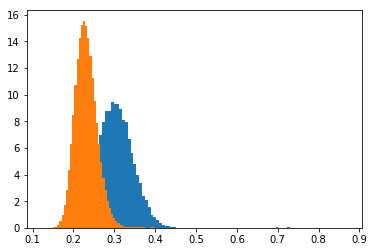

In [8]:
x = plt.hist(scores[targets == 1], bins = 100, density=True)
y = plt.hist(scores[targets == 0], bins = 100, density=True)